<a href="https://colab.research.google.com/github/Augy23/Tugas-Manchine-Learning/blob/main/UTS/UTS_Classification_Augrys_Farha_Sulistya_Negara.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import pandas as pd

# Load the dataset
file_path = '/content/drive/My Drive/diabetic_data.csv'
data = pd.read_csv(file_path)

# Display the first few rows to understand its structure
data.head(), data.info(), data.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

(   encounter_id  patient_nbr             race  gender      age weight  \
 0       2278392      8222157        Caucasian  Female   [0-10)      ?   
 1        149190     55629189        Caucasian  Female  [10-20)      ?   
 2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
 3        500364     82442376        Caucasian    Male  [30-40)      ?   
 4         16680     42519267        Caucasian    Male  [40-50)      ?   
 
    admission_type_id  discharge_disposition_id  admission_source_id  \
 0                  6                        25                    1   
 1                  1                         1                    7   
 2                  1                         1                    7   
 3                  1                         1                    7   
 4                  1                         1                    7   
 
    time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
 0                 1  ...          No      No     

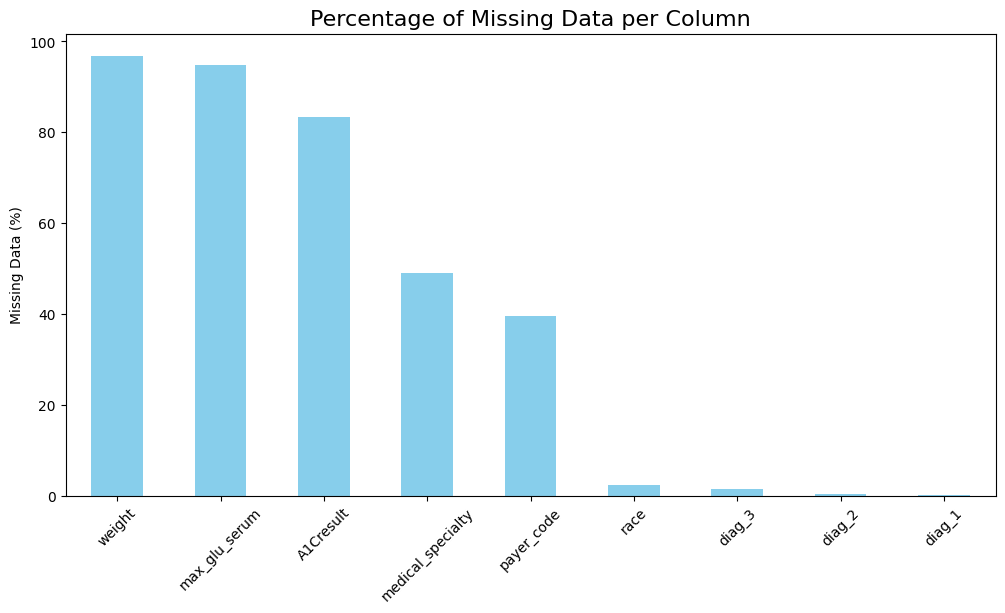

,0
race,2.233555
weight,96.858479
payer_code,39.557416
medical_specialty,49.082208
diag_1,0.020636
diag_2,0.351787
diag_3,1.398306
max_glu_serum,94.746772
A1Cresult,83.277322


In [19]:
# Replacing "?" with NaN for missing value analysis
data_cleaned = data.replace('?', pd.NA)

# Quick look at missing data percentage per column
missing_data_percentage = data_cleaned.isnull().mean() * 100

# Visualizing missing data
plt.figure(figsize=(12, 6))
missing_data_percentage[missing_data_percentage > 0].sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Percentage of Missing Data per Column', fontsize=16)
plt.ylabel('Missing Data (%)')
plt.xticks(rotation=45)
plt.show()

# Summary of missing data columns for insight
missing_data_percentage[missing_data_percentage > 0]


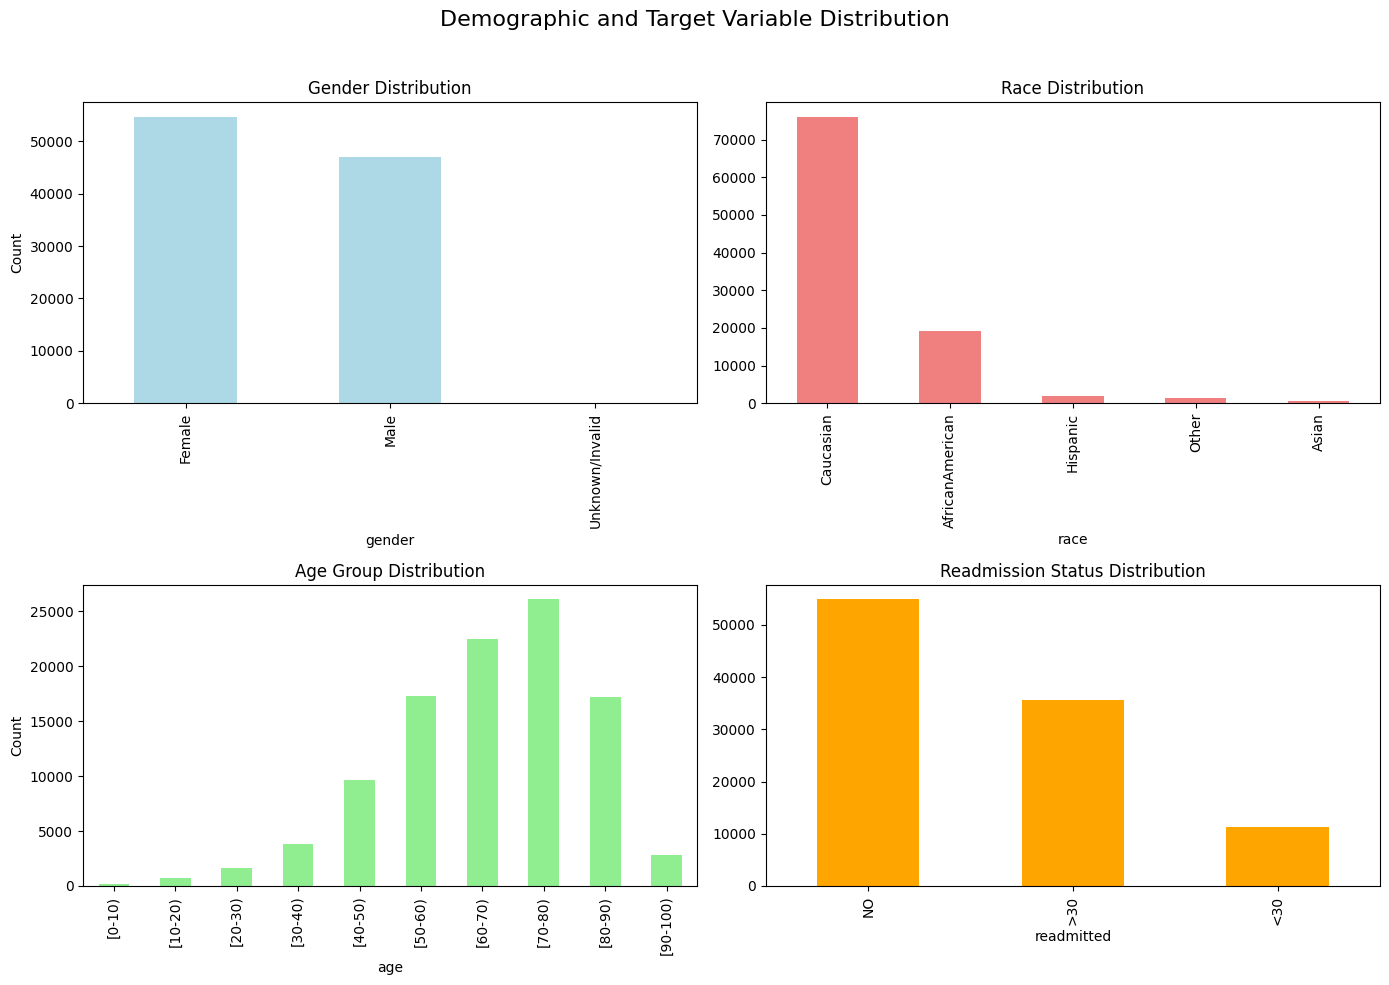

In [20]:
# Dropping columns with high missing data percentage
columns_to_drop = ['weight', 'medical_specialty', 'payer_code']
data_cleaned = data_cleaned.drop(columns=columns_to_drop, axis=1)

# Analyzing categorical demographics and target variable distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Demographic and Target Variable Distribution', fontsize=16)

# Gender Distribution
data_cleaned['gender'].value_counts().plot(kind='bar', ax=axes[0, 0], color='lightblue')
axes[0, 0].set_title('Gender Distribution')
axes[0, 0].set_ylabel('Count')

# Race Distribution
data_cleaned['race'].value_counts().plot(kind='bar', ax=axes[0, 1], color='lightcoral')
axes[0, 1].set_title('Race Distribution')

# Age Group Distribution
data_cleaned['age'].value_counts(sort=False).plot(kind='bar', ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title('Age Group Distribution')
axes[1, 0].set_ylabel('Count')

# Readmission Distribution
data_cleaned['readmitted'].value_counts().plot(kind='bar', ax=axes[1, 1], color='orange')
axes[1, 1].set_title('Readmission Status Distribution')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


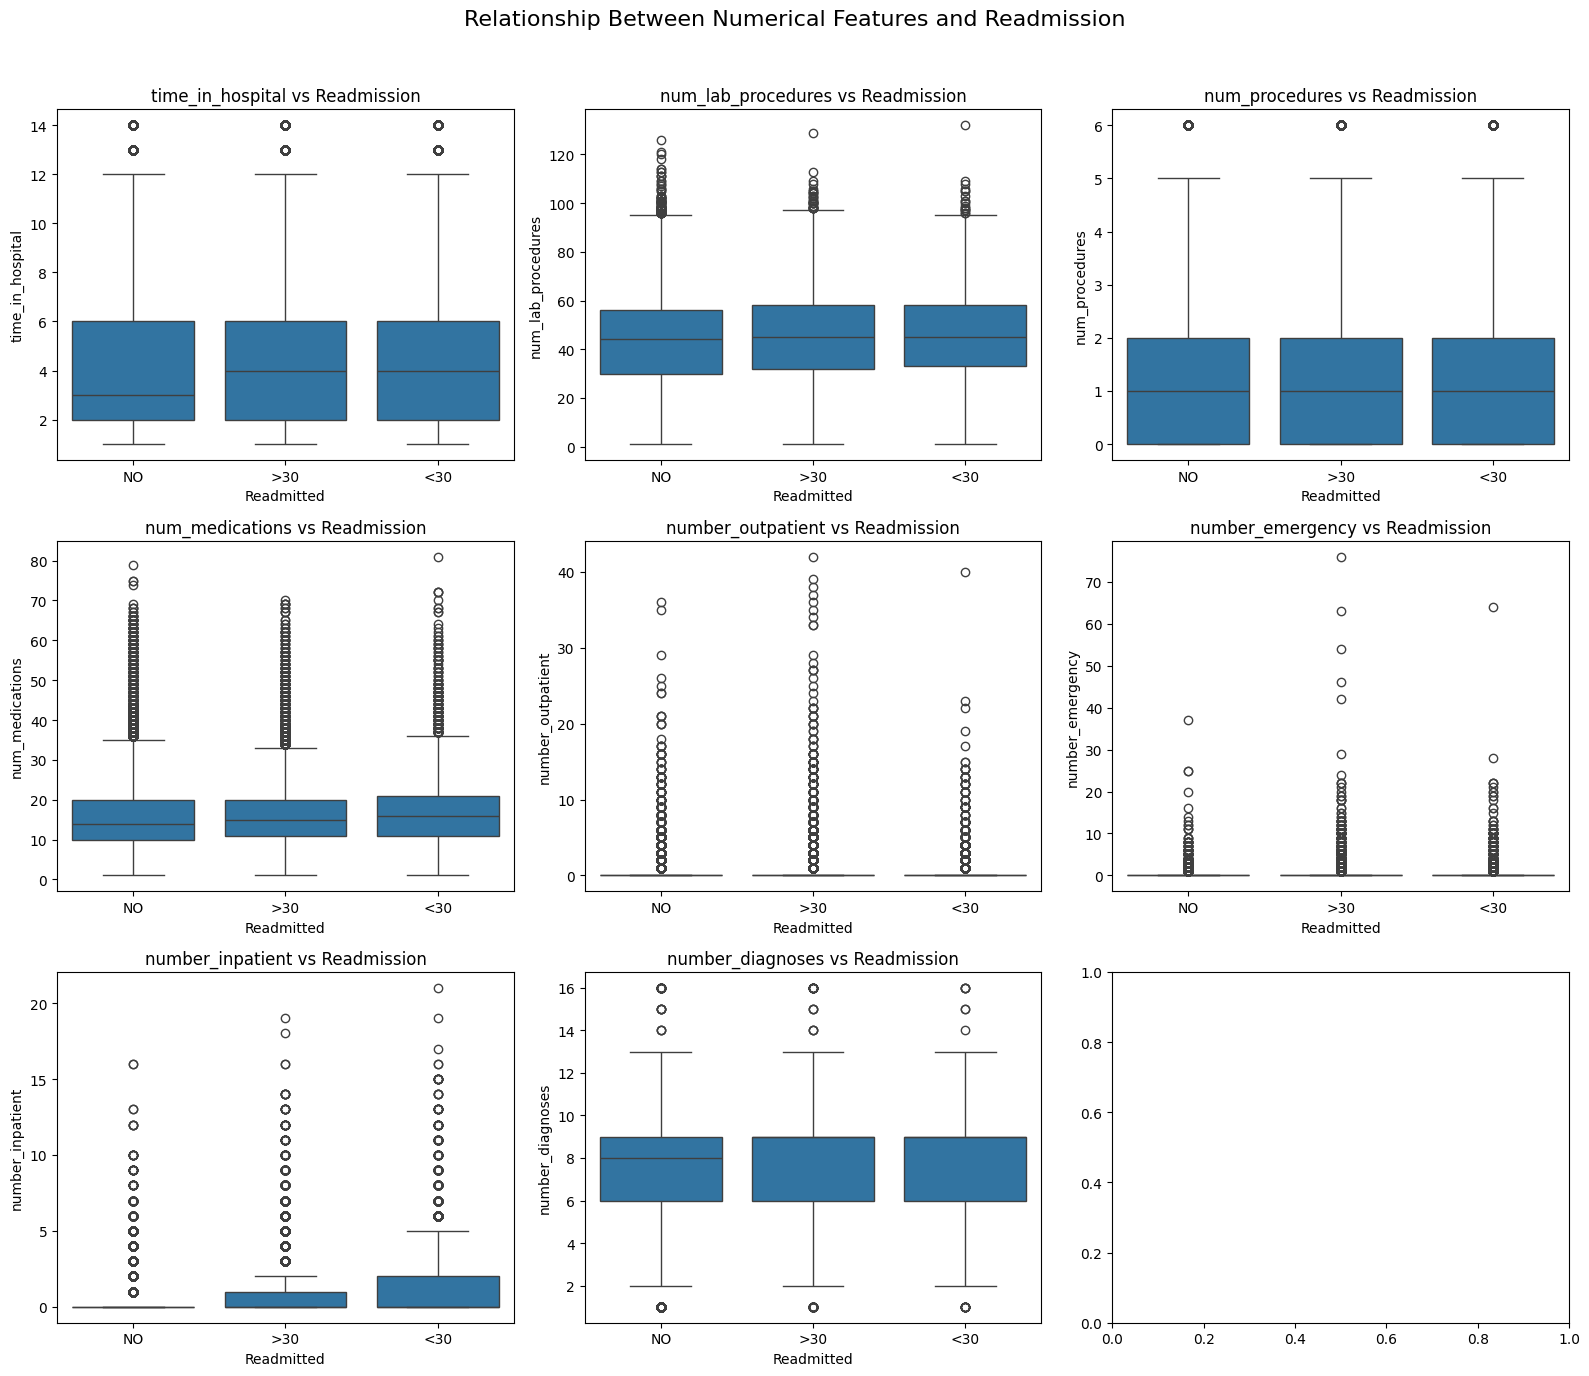

In [21]:
# Analyzing correlation between numerical variables and readmission
numerical_columns = ['time_in_hospital', 'num_lab_procedures', 'num_procedures',
                     'num_medications', 'number_outpatient', 'number_emergency',
                     'number_inpatient', 'number_diagnoses']

# Creating boxplots to visualize relationship
fig, axes = plt.subplots(3, 3, figsize=(16, 14))
fig.suptitle('Relationship Between Numerical Features and Readmission', fontsize=16)

for i, column in enumerate(numerical_columns):
    sns.boxplot(data=data_cleaned, x='readmitted', y=column, ax=axes[i // 3, i % 3])
    axes[i // 3, i % 3].set_title(f'{column} vs Readmission')
    axes[i // 3, i % 3].set_ylabel(column)
    axes[i // 3, i % 3].set_xlabel('Readmitted')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [22]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Selecting target and features
target = 'readmitted'
features = ['time_in_hospital', 'num_lab_procedures', 'num_procedures',
            'num_medications', 'number_outpatient', 'number_emergency',
            'number_inpatient', 'number_diagnoses']

X = data_cleaned[features]
y = data_cleaned[target]

# Encoding categorical target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing: Standardize numerical features
preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), features)]
)

# Define classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "k-NN": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Initialize results dictionary
results = {}

# Loop through classifiers and train pipelines
for name, clf in classifiers.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', clf)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {
        "Accuracy": accuracy,
        "Classification Report": classification_report(y_test, y_pred, target_names=label_encoder.classes_)
    }

# Display results
results


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:42:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


{'Logistic Regression': {'Accuracy': 0.5670629851626215,
  'Classification Report': '              precision    recall  f1-score   support\n\n         <30       0.46      0.01      0.01      2285\n         >30       0.49      0.22      0.31      7117\n          NO       0.58      0.91      0.71     10952\n\n    accuracy                           0.57     20354\n   macro avg       0.51      0.38      0.34     20354\nweighted avg       0.54      0.57      0.49     20354\n'},
 'Decision Tree': {'Accuracy': 0.4423209197209394,
  'Classification Report': '              precision    recall  f1-score   support\n\n         <30       0.13      0.14      0.14      2285\n         >30       0.37      0.38      0.37      7117\n          NO       0.57      0.55      0.56     10952\n\n    accuracy                           0.44     20354\n   macro avg       0.36      0.36      0.36     20354\nweighted avg       0.45      0.44      0.45     20354\n'},
 'k-NN': {'Accuracy': 0.49371130981625233,
  'Clas

In [28]:
# Creating a classification report summary table for all models
classification_report_data = {
    'Model': ['Logistic Regression', 'Decision Tree', 'k-NN', 'XGBoost'],
    '<30 Precision': [0.46, 0.13, 0.16, 0.31],
    '<30 Recall': [0.01, 0.14, 0.11, 0.02],
    '<30 F1-score': [0.01, 0.14, 0.13, 0.03],
    '>30 Precision': [0.49, 0.37, 0.40, 0.48],
    '>30 Recall': [0.22, 0.38, 0.40, 0.31],
    '>30 F1-score': [0.31, 0.37, 0.40, 0.38],
    'NO Precision': [0.58, 0.57, 0.60, 0.60],
    'NO Recall': [0.91, 0.55, 0.63, 0.85],
    'NO F1-score': [0.71, 0.56, 0.62, 0.70],
    'Accuracy': [0.5671, 0.4423, 0.4937, 0.5685]
}

# Creating the DataFrame for classification report
df_classification_report = pd.DataFrame(classification_report_data)

# Displaying the classification report table
df_classification_report


,Model,<30 Precision,<30 Recall,<30 F1-score,>30 Precision,>30 Recall,>30 F1-score,NO Precision,NO Recall,NO F1-score,Accuracy
0,Logistic Regression,0.46,0.01,0.01,0.49,0.22,0.31,0.58,0.91,0.71,0.5671
1,Decision Tree,0.13,0.14,0.14,0.37,0.38,0.37,0.57,0.55,0.56,0.4423
2,k-NN,0.16,0.11,0.13,0.40,0.40,0.40,0.60,0.63,0.62,0.4937
3,XGBoost,0.31,0.02,0.03,0.48,0.31,0.38,0.60,0.85,0.70,0.5685
